<a href="https://colab.research.google.com/github/graceebc9/Arch_Class/blob/main/train_svi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Train DCNN on facades for architecture Classification 


In [1]:
!pip install wandb
import wandb
!pip install pytorch_lightning 
import pytorch_lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:


#Store the PyTorch Lightning Data Modules and Model Classes 

import pytorch_lightning as pl
from pytorch_lightning import LightningDataModule ,Callback
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.loggers import WandbLogger
import wandb
from torch.utils.data import Dataset, DataLoader
from torchvision import  utils
import torchvision.transforms as T
import torchvision
import torchvision.models as models
import torch.optim as optim
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

torch.manual_seed(17)
import seaborn as sn
import matplotlib.pyplot as plt


from torchmetrics.classification import Accuracy, Recall
from torchmetrics import Precision, JaccardIndex, ConfusionMatrix
from torch.nn import  NLLLoss


import numpy as np
import glob
import random

import sys
from PIL import Image
import random
import os
import glob


from pytorch_lightning.callbacks import ModelCheckpoint

import torchvision.models as models
import torch
import pandas as pd
import wandb 
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
import pytorch_lightning as pl

In [3]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
base_dir = '/content/gdrive/MyDrive'

import sys
sys.path.insert(0, base_dir + '/HurricanDamage_Data')

from src import    ImagePredictionLogger, ImagePredictionLogger_table, extract_predictions

In [5]:


import os
from typing import Tuple
import os
from typing import Optional
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

import torchvision.transforms as T

import torch
from torch.autograd import Variable as V
import torchvision.models as models
from torchvision import transforms as trn
from torch.nn import functional as F
import os
import pytorch_lightning as pl

import torch
import torch.nn as nn
import torchvision.models as models

import numpy as np
from typing import Optional

import os
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler



In [6]:


class StreetViewData(Dataset):
    def __init__(self, root_dir: str, transform: Optional[transforms.Compose] = None):
        self.root_dir = root_dir
        self.transform = transform

        self.classes = os.listdir(root_dir)
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}
        self.idx_to_classes = {str(i): cls_name for i, cls_name in enumerate(self.classes)}

        self.samples = []

        print(self.classes)
        for class_name in self.classes:
            class_dir = os.path.join(self.root_dir, class_name)
            for i in range(3700):
                
                sample_path = os.path.join(class_dir, f"gsv_{i}.jpg")
                if not os.path.exists(sample_path):
                    None
                else:
                    self.samples.append((sample_path, self.class_to_idx[class_name]))
               

    def classes_dict(self):
      return self.idx_to_classes

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, index):
        sample_path, label = self.samples[index]

        with open(sample_path, "rb") as f:
            sample = Image.open(f).convert("RGB")
            left = 170
            top = 250
            right = 430
            bottom = 10
            sample = sample.crop((left, bottom, right, top))

        if self.transform:
            sample = self.transform(sample)

        return sample, label

class MyDataModule(pl.LightningDataModule):
    def __init__(self, data_dir, batch_size, transform=None, num_workers=4):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.transform = T.Compose([ T.Resize( size = (224, 224) ), T.ToTensor() ])       
        self.dataset = StreetViewData(data_dir, self.transform)

       
        

    def setup(self, stage=None): 
        # split into train, val, and test sets
        num_samples = len(self.dataset)
        indices = list(range(num_samples))
        split_train = int(np.floor(0.7 * num_samples))
        split_val = int(np.floor(0.15 * num_samples))
        np.random.shuffle(indices)
        train_indices, val_indices, test_indices = indices[:split_train], indices[split_train:split_train+split_val], indices[split_train+split_val:]
        print('Num train:{} Num val:{} Num test:{}'.format(len(train_indices), len(val_indices), len(test_indices)) )
        print('total num: {}  total sum: {}'.format(num_samples, (len(train_indices)+ len(val_indices)+ len(test_indices))))
        # define samplers
        train_sampler = SubsetRandomSampler(train_indices)
        val_sampler = SubsetRandomSampler(val_indices)
        test_sampler = SubsetRandomSampler(test_indices)

        
        # set up data loaders
        self.train_loader = DataLoader(self.dataset, batch_size=self.batch_size,
                                        sampler=train_sampler, num_workers=self.num_workers)
        self.val_loader = DataLoader(self.dataset, batch_size=self.batch_size,
                                        sampler=val_sampler, num_workers=self.num_workers)
        self.test_loader = DataLoader(self.dataset, batch_size=self.batch_size,
                                      sampler=test_sampler, num_workers=self.num_workers)
    
    

    def train_dataloader(self):
        return self.train_loader

    def val_dataloader(self):
        return self.val_loader

    def test_dataloader(self):
        return self.test_loader


In [7]:

import matplotlib.pyplot as plt
import seaborn as sns

In [61]:


class TransferLearning(pl.LightningModule):
    """
        Transfer learning data modules, works for ResNet Architectures 
        model: pytorch Resnet18 / 50 etc 
    """

    def __init__(self, model, learning_rate, optimiser = 'Adam', class_names=None):
        super().__init__()
        
        self.optimiser = optimiser
        self.thresh  =  0.5
        self.save_hyperparameters()
        self.learning_rate = learning_rate
        self.class_names = class_names
        
        #add metrics for tracking 
        self.accuracy = Accuracy(task= 'multiclass', num_classes=9 )
        self.loss= nn.CrossEntropyLoss()
        self.recall = Recall(task= 'multiclass', num_classes=9, threshold=self.thresh, average ='macro')
        self.prec = Precision( task= 'multiclass', num_classes=9, average='macro')
        self.jacq_ind = JaccardIndex(task= 'multiclass', num_classes=9)
        self.confmat = ConfusionMatrix(task="multiclass", num_classes=9)


        # init model
        backbone = model
        num_filters = backbone.fc.in_features
        layers = list(backbone.children())[:-1]
        self.feature_extractor = nn.Sequential(*layers)

        # use the pretrained model to classify damage 2 classes
        num_target_classes = 9
        self.classifier = nn.Linear(num_filters, num_target_classes)

    def forward(self, x):
        self.feature_extractor.eval()
        with torch.no_grad():
            representations = self.feature_extractor(x).flatten(1)
        x = self.classifier(representations)
        return x
    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss(logits, y)
        
        # training metrics
        preds = torch.argmax(logits, dim=1)
        acc = self.accuracy(preds, y)
        recall = self.recall(preds, y)
        precision = self.prec(preds, y)
        jac = self.jacq_ind(preds, y)
        

        wandb.log({"train_loss": loss})   
        self.log('train_loss', loss, on_step=True, on_epoch=True, logger=True)
        self.log('train_acc', acc, on_step=True, on_epoch=True, logger=True)
        self.log('train_recall', recall, on_step=True, on_epoch=True, logger=True)
        self.log('train_precision', precision, on_step=True, on_epoch=True, logger=True)
        self.log('train_jacc', jac, on_step=True, on_epoch=True, logger=True)
        
        return loss
  
    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss(logits, y)

        # validation metrics
        preds = torch.argmax(logits, dim=1)
        acc = self.accuracy(preds, y)
        recall = self.recall(preds, y)
        precision = self.prec(preds, y)
        jac = self.jacq_ind(preds, y)
        self.confmat.update(preds, y)
        print(acc, recall, precision )
        

        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', acc, prog_bar=True)
        self.log('val_recall', recall, prog_bar=True)
        self.log('val_precision', precision, prog_bar=True)
        self.log('val_jacc', jac, prog_bar=True)
        
        return  loss
      

    def on_validation_epoch_end(self):
        confmat = self.confmat.compute()
        class_names = self.class_names
        num_classes = len(class_names)

        df_cm = pd.DataFrame(confmat.cpu().numpy() , index = [i for i in class_names], columns = [i for i in class_names])
        df_cm.to_csv('raw_nums.csv') # used this to validate the number of val samples
        print('Num of val samples: {}. Check this aligns with the numbers from the dataloader'.format(df_cm.sum(axis=1).sum() ))
        #normalise the confusion matrix 
        norm =  np.sum(df_cm, axis=1)
        normalized_cm = (df_cm.T/norm).T
        #validate the confusion matrix sums to num of classes
       
        print( normalized_cm.sum(axis=1).sum() )
          

        normalized_cm.to_csv('norm_cdf.csv') 
        #log to wandb
        f, ax = plt.subplots(figsize = (15,10)) 
        sn.heatmap(normalized_cm, annot=True, ax=ax)
        wandb.log({"Validation Confusion Matrix ": wandb.Image(f) })
        self.confmat.reset()  #This was NEEDED otherwise the confusion matrix kept stacking the results

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss(logits, y)
        
        # validation metrics
        preds = torch.argmax(logits, dim=1)
        acc = self.accuracy(preds, y)
        recall = self.recall(preds, y)
        precision = self.prec(preds, y)
        jac = self.jacq_ind(preds, y)
        # confmat = self.confmat(preds, y)

        self.log('test_loss', loss, prog_bar=True)
        self.log('test_acc', acc, prog_bar=True)
        self.log('test_recall', recall, prog_bar=True)
        self.log('test_precision', precision, prog_bar=True)
        self.log('test_jacc', jac, prog_bar=True)
         
        # self.log('test_conf', confmat, on_step=False, on_epoch=True, logger=True)

        return loss
    def configure_optimizers(self,):
        print('Optimise with {}'.format(self.optimiser) )
        # optimizer = self.optimiser_dict[self.optimiser](self.parameters(), lr=self.learning_rate)
                
                # Support Adam, SGD, RMSPRop and Adagrad as optimizers.
        if self.optimiser == "Adam":
            optimiser = optim.AdamW(self.parameters(), lr = self.learning_rate)
        elif self.optimiser == "SGD":
            optimiser = optim.SGD(self.parameters(), lr = self.learning_rate)
        elif self.optimiser == "Adagrad":
            optimiser = optim.Adagrad(self.parameters(), lr = self.learning_rate)
        elif self.optimiser == "RMSProp":
            optimiser = optim.RMSprop(self.parameters(), lr = self.learning_rate)
        else:
            assert False, f"Unknown optimizer: \"{self.optimiser}\""

        return optimiser


In [62]:


dm = MyDataModule(data_dir="/content/gdrive/MyDrive/Non_Trads_FOI/Facades_SVI", batch_size=32)
dm.setup()

train_dataloader = dm.train_dataloader()
val_dataloader = dm.val_dataloader()

['wimpey no fines', 'reema', 'orlit', 'edlo', 'airey', 'weir', 'molems', 'wates', 'bisf']
Num train:3526 Num val:755 Num test:757
total num: 5038  total sum: 5038


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [63]:
#Parameters set for our Final Model config; using ResNet50 architecture
bs = 160
LR = 0.006607
optimiser = 'Adam'

model = TransferLearning(model=models.resnet50(weights='DEFAULT'), learning_rate = LR, optimiser = optimiser, class_names = dm.dataset.classes )

/usr/local/lib/python3.9/dist-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
  rank_zero_warn(


In [64]:
#needed for the val and test image loggers
val_samples = next(iter(dm.val_dataloader()))
# test_samples = next(iter(dm.test_shuffle_dataloader()))

In [65]:

wand_proj_name = 'test_svi'

wandb.init(project= wand_proj_name, entity='grace_ebc')

In [13]:

# wandb.init(project= wand_proj_name, entity='grace_ebc')

In [66]:
# #set up logger
wandb_logger = WandbLogger( job_type='train' )


/usr/local/lib/python3.9/dist-packages/pytorch_lightning/loggers/wandb.py:395: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


In [67]:

#set up our wandb trainer 
trainer = pl.Trainer(
                        max_epochs=50,
                        logger=wandb_logger,
                        callbacks=[ModelCheckpoint(save_weights_only=True, mode="max", monitor="val_acc"),
                                   ImagePredictionLogger(val_samples), 
                                   ImagePredictionLogger_table( val_samples, 'val' ),
                                  #  ImagePredictionLogger_table(test_samples, 'test'),
                                  EarlyStopping(monitor="val_acc", min_delta=0.00, patience=3, verbose=False, mode="max")
                                  ]

                        )  
pl.seed_everything(42) 

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:lightning_fabric.utilities.seed:Global seed set to 42


42

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name              | Type                      | Params
----------------------------------------------------------------
0 | accuracy          | MulticlassAccuracy        | 0     
1 | loss              | CrossEntropyLoss          | 0     
2 | recall            | MulticlassRecall          | 0     
3 | prec              | MulticlassPrecision       | 0     
4 | jacq_ind          | MulticlassJaccardIndex    | 0     
5 | confmat           | MulticlassConfusionMatrix | 0     
6 | feature_extractor | Sequential                | 23.5 M
7 | classifier        | Linear                    | 18.4 K
----------------------------------------------------------------
23.5 M    Trainable params
0         Non-trainable params
23.5 M    Total params
94.106    Total estimated model params size (MB)


Num train:3526 Num val:755 Num test:757
total num: 5038  total sum: 5038
Optimise with Adam


Sanity Checking: 0it [00:00, ?it/s]

tensor(0.0938, device='cuda:0') tensor(0.1296, device='cuda:0') tensor(0.0356, device='cuda:0')
tensor(0.1250, device='cuda:0') tensor(0.1519, device='cuda:0') tensor(0.0456, device='cuda:0')
Num of val samples: 64. Check this aligns with the numbers from the dataloader
9.0


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

tensor(0.7500, device='cuda:0') tensor(0.5833, device='cuda:0') tensor(0.6691, device='cuda:0')
tensor(0.7188, device='cuda:0') tensor(0.5873, device='cuda:0') tensor(0.5892, device='cuda:0')
tensor(0.7500, device='cuda:0') tensor(0.4644, device='cuda:0') tensor(0.5398, device='cuda:0')
tensor(0.5625, device='cuda:0') tensor(0.4690, device='cuda:0') tensor(0.4167, device='cuda:0')
tensor(0.7500, device='cuda:0') tensor(0.6984, device='cuda:0') tensor(0.6429, device='cuda:0')
tensor(0.5938, device='cuda:0') tensor(0.3075, device='cuda:0') tensor(0.3508, device='cuda:0')
tensor(0.7188, device='cuda:0') tensor(0.5840, device='cuda:0') tensor(0.5507, device='cuda:0')
tensor(0.6875, device='cuda:0') tensor(0.4397, device='cuda:0') tensor(0.5005, device='cuda:0')
tensor(0.8125, device='cuda:0') tensor(0.5812, device='cuda:0') tensor(0.5516, device='cuda:0')
tensor(0.6875, device='cuda:0') tensor(0.5132, device='cuda:0') tensor(0.5206, device='cuda:0')
tensor(0.5938, device='cuda:0') tensor(0

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Validation: 0it [00:00, ?it/s]

tensor(0.7188, device='cuda:0') tensor(0.4738, device='cuda:0') tensor(0.5542, device='cuda:0')
tensor(0.8125, device='cuda:0') tensor(0.5343, device='cuda:0') tensor(0.6173, device='cuda:0')
tensor(0.7812, device='cuda:0') tensor(0.4792, device='cuda:0') tensor(0.4382, device='cuda:0')
tensor(0.5938, device='cuda:0') tensor(0.4343, device='cuda:0') tensor(0.4913, device='cuda:0')
tensor(0.7812, device='cuda:0') tensor(0.4352, device='cuda:0') tensor(0.5238, device='cuda:0')
tensor(0.8125, device='cuda:0') tensor(0.7111, device='cuda:0') tensor(0.6667, device='cuda:0')
tensor(0.8750, device='cuda:0') tensor(0.6601, device='cuda:0') tensor(0.6379, device='cuda:0')
tensor(0.7500, device='cuda:0') tensor(0.6481, device='cuda:0') tensor(0.6528, device='cuda:0')
tensor(0.7500, device='cuda:0') tensor(0.4921, device='cuda:0') tensor(0.4183, device='cuda:0')
tensor(0.7188, device='cuda:0') tensor(0.5848, device='cuda:0') tensor(0.6690, device='cuda:0')
tensor(0.7500, device='cuda:0') tensor(0

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Validation: 0it [00:00, ?it/s]

tensor(0.7188, device='cuda:0') tensor(0.5285, device='cuda:0') tensor(0.6111, device='cuda:0')
tensor(0.7500, device='cuda:0') tensor(0.6407, device='cuda:0') tensor(0.7901, device='cuda:0')
tensor(0.8438, device='cuda:0') tensor(0.7407, device='cuda:0') tensor(0.8111, device='cuda:0')
tensor(0.7188, device='cuda:0') tensor(0.5630, device='cuda:0') tensor(0.6111, device='cuda:0')
tensor(0.8125, device='cuda:0') tensor(0.6959, device='cuda:0') tensor(0.6311, device='cuda:0')
tensor(0.8438, device='cuda:0') tensor(0.6358, device='cuda:0') tensor(0.7232, device='cuda:0')
tensor(0.8125, device='cuda:0') tensor(0.7026, device='cuda:0') tensor(0.6898, device='cuda:0')
tensor(0.8125, device='cuda:0') tensor(0.5972, device='cuda:0') tensor(0.5979, device='cuda:0')
tensor(0.7812, device='cuda:0') tensor(0.4111, device='cuda:0') tensor(0.4522, device='cuda:0')
tensor(0.7812, device='cuda:0') tensor(0.5693, device='cuda:0') tensor(0.5889, device='cuda:0')
tensor(0.7500, device='cuda:0') tensor(0

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Validation: 0it [00:00, ?it/s]

tensor(0.7500, device='cuda:0') tensor(0.4976, device='cuda:0') tensor(0.4444, device='cuda:0')
tensor(0.8125, device='cuda:0') tensor(0.7418, device='cuda:0') tensor(0.8333, device='cuda:0')
tensor(0.8438, device='cuda:0') tensor(0.6963, device='cuda:0') tensor(0.6984, device='cuda:0')
tensor(0.7500, device='cuda:0') tensor(0.3679, device='cuda:0') tensor(0.3506, device='cuda:0')
tensor(0.7500, device='cuda:0') tensor(0.4488, device='cuda:0') tensor(0.4167, device='cuda:0')
tensor(0.8125, device='cuda:0') tensor(0.6361, device='cuda:0') tensor(0.6285, device='cuda:0')
tensor(0.7188, device='cuda:0') tensor(0.7640, device='cuda:0') tensor(0.8148, device='cuda:0')
tensor(0.8125, device='cuda:0') tensor(0.5764, device='cuda:0') tensor(0.5926, device='cuda:0')
tensor(0.7188, device='cuda:0') tensor(0.5111, device='cuda:0') tensor(0.5963, device='cuda:0')
tensor(0.9062, device='cuda:0') tensor(0.6593, device='cuda:0') tensor(0.6250, device='cuda:0')
tensor(0.7500, device='cuda:0') tensor(0

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Validation: 0it [00:00, ?it/s]

tensor(0.7500, device='cuda:0') tensor(0.2904, device='cuda:0') tensor(0.4133, device='cuda:0')
tensor(0.8438, device='cuda:0') tensor(0.5185, device='cuda:0') tensor(0.5692, device='cuda:0')
tensor(0.7500, device='cuda:0') tensor(0.6296, device='cuda:0') tensor(0.6352, device='cuda:0')
tensor(0.9062, device='cuda:0') tensor(0.8175, device='cuda:0') tensor(0.8063, device='cuda:0')
tensor(0.6562, device='cuda:0') tensor(0.6328, device='cuda:0') tensor(0.6765, device='cuda:0')
tensor(0.8750, device='cuda:0') tensor(0.6389, device='cuda:0') tensor(0.5272, device='cuda:0')
tensor(0.7500, device='cuda:0') tensor(0.7963, device='cuda:0') tensor(0.7275, device='cuda:0')
tensor(0.7812, device='cuda:0') tensor(0.4931, device='cuda:0') tensor(0.5979, device='cuda:0')
tensor(0.8438, device='cuda:0') tensor(0.6875, device='cuda:0') tensor(0.6852, device='cuda:0')
tensor(0.7500, device='cuda:0') tensor(0.4766, device='cuda:0') tensor(0.4907, device='cuda:0')
tensor(0.7812, device='cuda:0') tensor(0

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Validation: 0it [00:00, ?it/s]

tensor(0.7812, device='cuda:0') tensor(0.7936, device='cuda:0') tensor(0.8056, device='cuda:0')
tensor(0.8750, device='cuda:0') tensor(0.6324, device='cuda:0') tensor(0.6046, device='cuda:0')
tensor(0.7188, device='cuda:0') tensor(0.5074, device='cuda:0') tensor(0.4704, device='cuda:0')
tensor(0.7188, device='cuda:0') tensor(0.5071, device='cuda:0') tensor(0.5905, device='cuda:0')
tensor(0.7188, device='cuda:0') tensor(0.6195, device='cuda:0') tensor(0.6991, device='cuda:0')
tensor(0.7500, device='cuda:0') tensor(0.5397, device='cuda:0') tensor(0.6389, device='cuda:0')
tensor(0.6875, device='cuda:0') tensor(0.6563, device='cuda:0') tensor(0.5899, device='cuda:0')
tensor(0.5625, device='cuda:0') tensor(0.5313, device='cuda:0') tensor(0.6245, device='cuda:0')
tensor(0.8750, device='cuda:0') tensor(0.7074, device='cuda:0') tensor(0.6892, device='cuda:0')
tensor(0.8438, device='cuda:0') tensor(0.7809, device='cuda:0') tensor(0.7509, device='cuda:0')
tensor(0.7500, device='cuda:0') tensor(0

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Validation: 0it [00:00, ?it/s]

tensor(0.8438, device='cuda:0') tensor(0.7315, device='cuda:0') tensor(0.7741, device='cuda:0')
tensor(0.7500, device='cuda:0') tensor(0.6204, device='cuda:0') tensor(0.7889, device='cuda:0')
tensor(0.7500, device='cuda:0') tensor(0.5010, device='cuda:0') tensor(0.5750, device='cuda:0')
tensor(0.7500, device='cuda:0') tensor(0.5366, device='cuda:0') tensor(0.5556, device='cuda:0')
tensor(0.7500, device='cuda:0') tensor(0.7003, device='cuda:0') tensor(0.6726, device='cuda:0')
tensor(0.8125, device='cuda:0') tensor(0.5212, device='cuda:0') tensor(0.4833, device='cuda:0')
tensor(0.6562, device='cuda:0') tensor(0.4028, device='cuda:0') tensor(0.4591, device='cuda:0')
tensor(0.6562, device='cuda:0') tensor(0.4259, device='cuda:0') tensor(0.4320, device='cuda:0')
tensor(0.8438, device='cuda:0') tensor(0.8162, device='cuda:0') tensor(0.8333, device='cuda:0')
tensor(0.5938, device='cuda:0') tensor(0.4306, device='cuda:0') tensor(0.5173, device='cuda:0')
tensor(0.8125, device='cuda:0') tensor(0

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Validation: 0it [00:00, ?it/s]

tensor(0.6250, device='cuda:0') tensor(0.4521, device='cuda:0') tensor(0.5709, device='cuda:0')
tensor(0.9062, device='cuda:0') tensor(0.6508, device='cuda:0') tensor(0.6264, device='cuda:0')
tensor(0.7500, device='cuda:0') tensor(0.5687, device='cuda:0') tensor(0.6278, device='cuda:0')
tensor(0.8750, device='cuda:0') tensor(0.6286, device='cuda:0') tensor(0.6211, device='cuda:0')
tensor(0.8438, device='cuda:0') tensor(0.5730, device='cuda:0') tensor(0.5713, device='cuda:0')
tensor(0.7188, device='cuda:0') tensor(0.6167, device='cuda:0') tensor(0.6238, device='cuda:0')
tensor(0.7812, device='cuda:0') tensor(0.7058, device='cuda:0') tensor(0.6667, device='cuda:0')
tensor(0.6875, device='cuda:0') tensor(0.4156, device='cuda:0') tensor(0.4248, device='cuda:0')
tensor(0.6562, device='cuda:0') tensor(0.3963, device='cuda:0') tensor(0.4889, device='cuda:0')
tensor(0.7812, device='cuda:0') tensor(0.5455, device='cuda:0') tensor(0.5608, device='cuda:0')
tensor(0.7188, device='cuda:0') tensor(0

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Validation: 0it [00:00, ?it/s]

tensor(0.7812, device='cuda:0') tensor(0.5929, device='cuda:0') tensor(0.5365, device='cuda:0')
tensor(0.9375, device='cuda:0') tensor(0.7500, device='cuda:0') tensor(0.7630, device='cuda:0')
tensor(0.8438, device='cuda:0') tensor(0.5463, device='cuda:0') tensor(0.6402, device='cuda:0')
tensor(0.8750, device='cuda:0') tensor(0.6889, device='cuda:0') tensor(0.7074, device='cuda:0')
tensor(0.7188, device='cuda:0') tensor(0.5407, device='cuda:0') tensor(0.7302, device='cuda:0')
tensor(0.9062, device='cuda:0') tensor(0.6597, device='cuda:0') tensor(0.6166, device='cuda:0')
tensor(0.8750, device='cuda:0') tensor(0.5767, device='cuda:0') tensor(0.6286, device='cuda:0')
tensor(0.8438, device='cuda:0') tensor(0.5305, device='cuda:0') tensor(0.6047, device='cuda:0')
tensor(0.7500, device='cuda:0') tensor(0.6226, device='cuda:0') tensor(0.6556, device='cuda:0')
tensor(0.6562, device='cuda:0') tensor(0.5728, device='cuda:0') tensor(0.5578, device='cuda:0')
tensor(0.7500, device='cuda:0') tensor(0

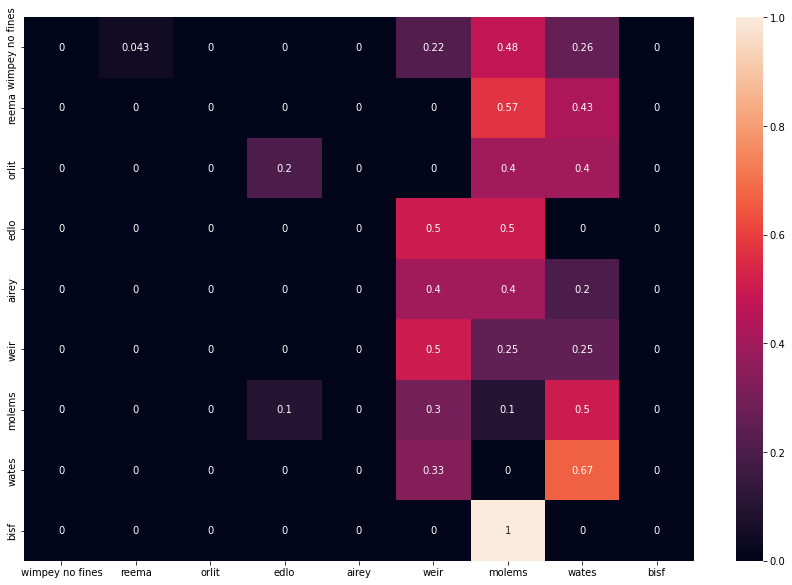

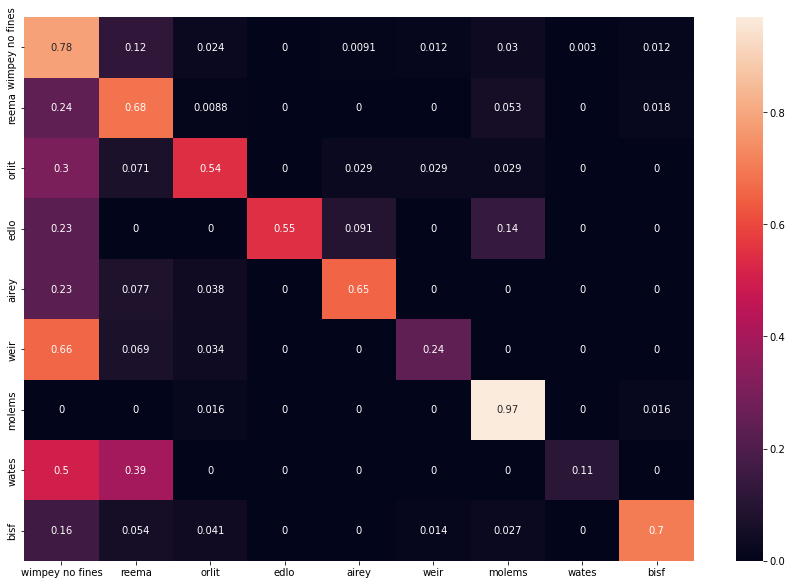

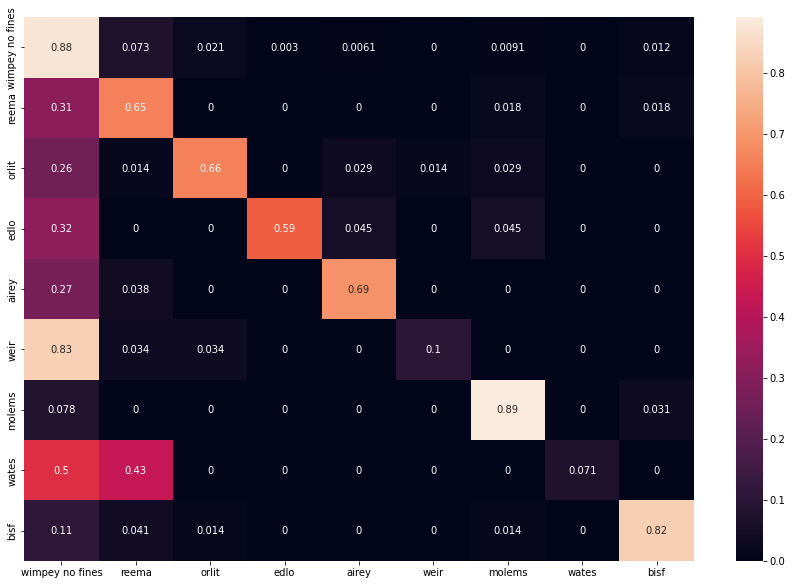

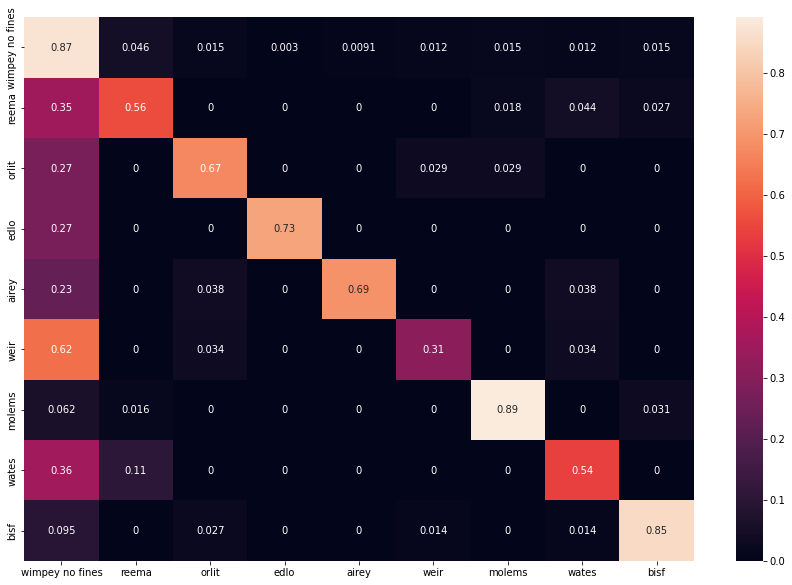

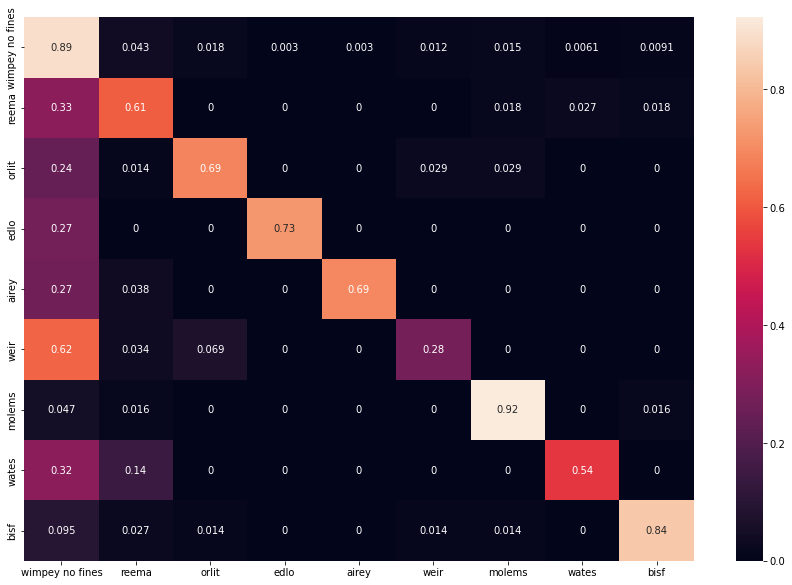

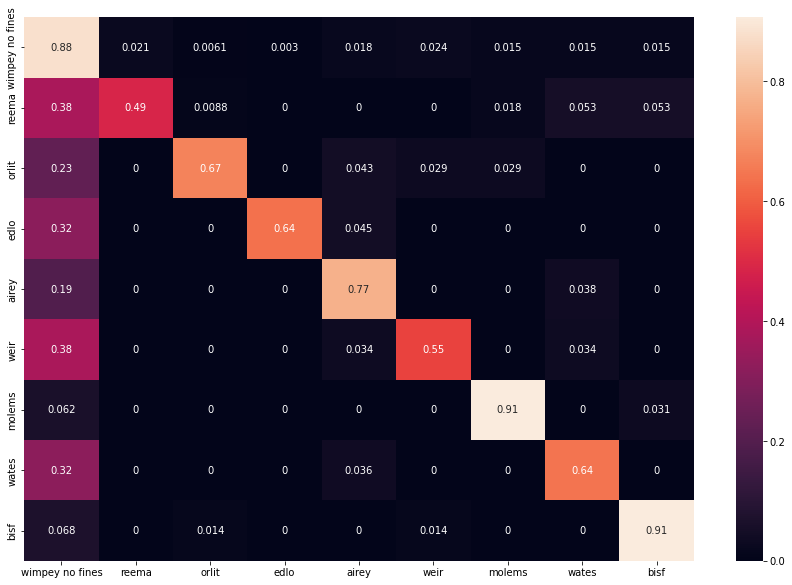

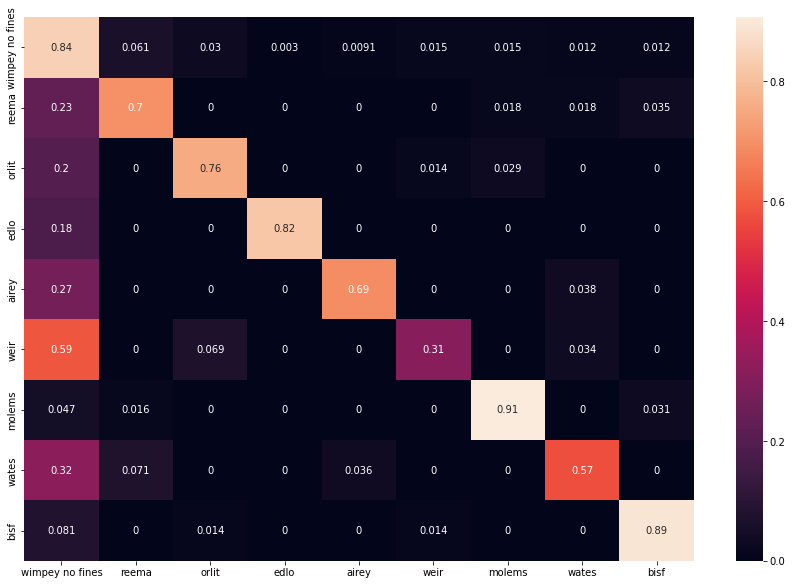

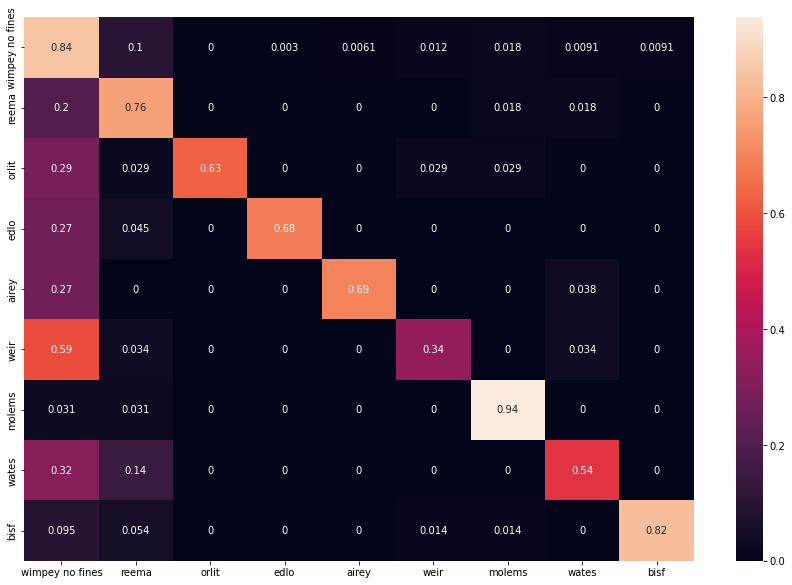

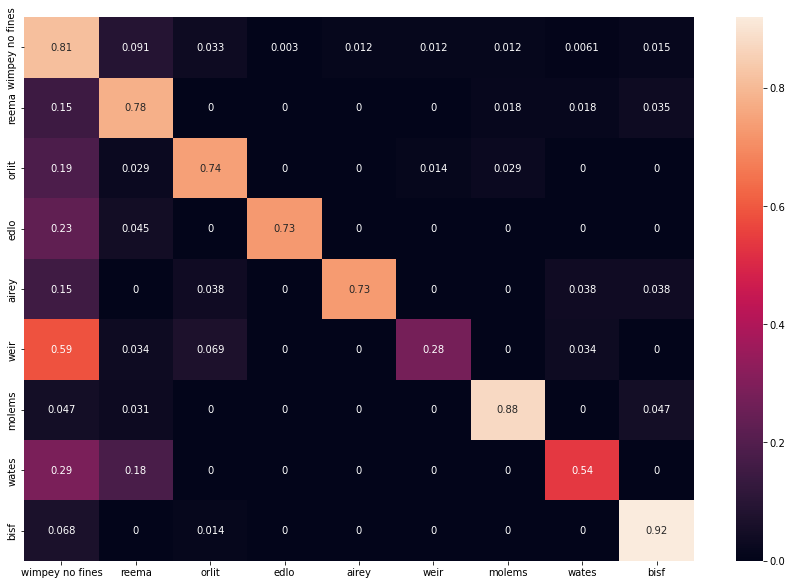

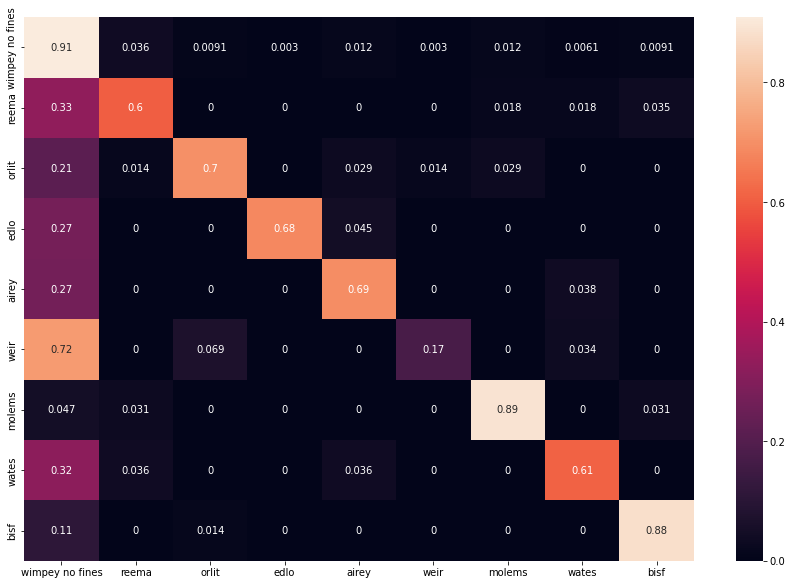

In [68]:

#fits model using datamodule provided
trainer.fit(model, dm)

In [69]:
#test trained model on test dataloader 
trainer.test(dataloaders = dm.test_dataloader())
wandb.finish()

/usr/local/lib/python3.9/dist-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:148: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
  rank_zero_warn(
/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at ./lightning_logs/z8582b42/che

Num train:3526 Num val:755 Num test:757
total num: 5038  total sum: 5038


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.8005284070968628
        test_jacc           0.5436128973960876
        test_loss           0.5854918360710144
     test_precision         0.6376307010650635
       test_recall          0.6037177443504333
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇█
test_acc,▁
test_jacc,▁
test_loss,▁
test_precision,▁
test_recall,▁
train_acc_epoch,▁▄▆▆▇▇███
train_acc_step,▁▄▅▅▆▇▇▇▇▇▆███▇████
train_jacc_epoch,▁▄▆▆▇▇███
train_jacc_step,▁▂▄▄▅▆▄▆▆▆▆▆█▃▆▇▆▅▆
train_loss,█▆▅▃▃▅▄▃▃▃▃▃▂▂▂▂▁▂▂▃▂▂▂▂▁▂▂▁▁▁▁▁▁▂▂▁▁▂▁▁


In [ ]:
# if model_out_path is not None:
#   torch.save(model.state_dict(), model_out_path)

In [28]:
cdf = pd.read_csv('raw_nums.csv')
cdf.set_index('Unnamed: 0', inplace=True)

# norm =  np.sum(cdf, axis=1)
# cdf = cdf/norm



# sn.heatmap(cdf, annot=True)
# plt.figure(figsize = (25,17))



In [38]:

cdf

,wimpey no fines,reema,orlit,edlo,airey,weir,molems,wates,bisf
Unnamed: 0,,,,,,,,,
wimpey no fines,292,19,1,1,1,4,3,0,3
reema,39,80,0,0,0,2,1,0,3
orlit,22,2,44,0,0,2,0,0,0
edlo,1,0,0,14,0,0,0,0,0
airey,4,0,0,0,17,0,0,0,0
weir,16,1,2,0,0,24,0,0,1
molems,2,0,0,0,0,0,39,0,0
wates,14,9,0,0,0,1,0,9,0
bisf,4,6,0,0,0,0,0,0,72


In [34]:

cdf
292+ 80 +44+14+17+24+39+9+72

591

In [ ]:

precision = correctly pred pos / all pred pos 
micro: true pos and false pos then calc precision 
macro: calc precision per class and average them 

In [45]:

true_positives

array([292,  80,  44,  14,  17,  24,  39,   9,  72])

In [46]:

np.sum(cdf, axis=0)

wimpey no fines    394
reema              117
orlit               47
edlo                15
airey               18
weir                33
molems              43
wates                9
bisf                79
dtype: int64

In [47]:

false_positives

wimpey no fines    102
reema               37
orlit                3
edlo                 1
airey                1
weir                 9
molems               4
wates                0
bisf                 7
dtype: int64

In [58]:

import numpy as np



# calculate true positives and false positives for each class
true_positives = np.diag(cdf)
false_positives = np.sum(cdf, axis=0) - true_positives

# calculate micro-precision
micro_precision = np.sum(true_positives) / (np.sum(true_positives) + np.sum(false_positives))

print("Micro-Precision: {:.15f}".format(micro_precision))


# calculate total correct predictions
total_correct = np.trace(cdf)

# calculate total predictions
total_predictions = np.sum(cdf).sum()

# calculate accuracy
accuracy = total_correct / total_predictions

print("Accuracy: {:.15f}".format(accuracy))


true_positives = np.diag(cdf)
false_negatives = np.sum(cdf, axis=1) - true_positives

# calculate micro-recall
micro_recall = np.sum(true_positives) / (np.sum(true_positives) + np.sum(false_negatives))

print("Micro-Recall: {:.15f}".format(micro_recall))


Micro-Precision: 0.782781456953642
Accuracy: 0.782781456953642
Micro-Recall: 0.782781456953642


In [60]:
conf_matrix = cdf
# calculate true positives and false positives for each class
true_positives = np.diag(conf_matrix)
false_positives = np.sum(conf_matrix, axis=0) - true_positives

# calculate macro-precision and micro-precision
macro_precision = np.mean(true_positives / (true_positives + false_positives))

# calculate true positives and false negatives for each class
true_positives = np.diag(conf_matrix)
false_negatives = np.sum(conf_matrix, axis=1) - true_positives

# calculate macro-recall and micro-recall
macro_recall = np.mean(true_positives / (true_positives + false_negatives))

# calculate accuracy
total_correct = np.trace(conf_matrix)
total_predictions = np.sum(conf_matrix).sum()
accuracy = total_correct / total_predictions

print("Macro-Precision: {:.4f}".format(macro_precision))
print("Macro-Recall: {:.4f}".format(macro_recall))
print("Accuracy: {:.4f}".format(accuracy))

Macro-Precision: 0.8649
Macro-Recall: 0.7289
Accuracy: 0.7828


In [41]:
tp = 292 
fp= 39 + 22+1+4+16+2+14+4 

tp / (tp+fp)


0.7411167512690355

In [36]:

591 / 755

0.7827814569536424

In [37]:

0.7828

0.7828

In [35]:

cdf.sum(axis=1)

Unnamed: 0
wimpey no fines    324
reema              125
orlit               70
edlo                15
airey               21
weir                44
molems              41
wates               33
bisf                82
dtype: int64

In [ ]:

f, ax = plt.subplots(figsize = (15,10)) 

sn.heatmap(cdf, annot=True, ax=ax)



In [ ]:


sn.heatmap(cdf, annot=True)
plt.figure(figsize = (25,17))



In [ ]:
listodx = sum(all_labels, [])


In [ ]:

dl = dm.val_dataloader()

In [ ]:

dl = dm.test_dataloader()


all_labels = []
for x in dl:
  images, labels = x
  all_labels.append(labels.tolist())

rdf = pd.DataFrame()
rdf['labels'] =  sum(all_labels, [])
rdf['name'] = [cl_dict[str(x)] for x in rdf['labels'] ]

rdf.groupby('name').count()

In [ ]:


dl = dm.val_dataloader()

all_labels = []
for x in dl:
  images, labels = x
  all_labels.append(labels.tolist())

rdf = pd.DataFrame()
rdf['labels'] =  sum(all_labels, [])
rdf['name'] = [cl_dict[str(x)] for x in rdf['labels'] ]

rdf.groupby('name').count()

In [ ]:

dl = dm.train_dataloader()

all_labels = []
for x in dl:
  images, labels = x
  all_labels.append(labels.tolist())

rdf = pd.DataFrame()
rdf['labels'] =  sum(all_labels, [])
rdf['name'] = [cl_dict[str(x)] for x in rdf['labels'] ]

rdf.groupby('name').count()

In [ ]:


def extract_predictions(dm, model, output_location = None):
    #Extract the Ground truth and Predictions 
    ground_truth = [] 
    list_output = []
    predictions = []

    test_dataloader = dm.test_dataloader()
  

    for batch in test_dataloader:
      label = sample[1]
      data = sample[0]
      ground_truth.append(label)
    print('Ground truth list created')

    test_ids = dm.test_ids
    print('Num of Test IDs is {}, Num of Ground Truth labels is {}'.format(len(test_ids), len(ground_truth)) )


    model.eval()
    for x in dm.test_dataloader():
      output = model(x[0])
      x = torch.argmax(output, dim=1)
      x= torch.flatten(x)
      list_output.append(x)

    for x in list_output:
      x= x.tolist()
      # print(x)
      for y in x:
        predictions.append(y)
    print('Prediction list created')

    # #create df of predictions and save 
    df = pd.DataFrame( {'TestId': test_ids , 'GroundTruth' :ground_truth, 'Preds' : predictions   })
    # if output_location is not None: 
    #   df.to_csv(output_location )
    return df 

In [ ]:

test_dataset= dm.test_dataloader

for sample in test_dataset:
      label = sample[1]
      data = sample[0]

In [ ]:

test_dataset

In [ ]:
#creates predictions and if output_location not None, saves them 
extract_predictions(dm, model, base_dir)

In [ ]:
val_dataloader

In [ ]:
scd = StreetViewData("/content/gdrive/MyDrive/Non_Trads_FOI/Facades_SVI")

In [ ]:
idx =100
idx=200
idx=2200
path  = scd.samples[idx][0]
label = scd.samples[idx][1]

sample = Image.open(path).convert("RGB")
sample.show()

width , height = sample.size

left = 170
top = 250
right = 430
bottom = 10
print(top, bottom )
im1 = sample.crop((left, bottom, right, top))







im1.show()

In [ ]:
im1

In [ ]:
model(val_samples)

In [ ]:

trainer.predict(model, val_dataloader) 